In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Flatten, LeakyReLU, Conv2D, Conv2DTranspose, BatchNormalization
from tensorflow.keras.optimizers import Adam

In [2]:
# Load MNIST dataset
(X_train, _), (_, _) = mnist.load_data()

# Normalize to [-1, 1] (required for tanh activation in generator)
X_train = (X_train - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=-1)  # Add channel dimension (28x28x1)

print(f"Dataset shape: {X_train.shape}")  # Output: (60000, 28, 28, 1)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Dataset shape: (60000, 28, 28, 1)


In [3]:
def define_generator(latent_dim):
    model = Sequential()

    # Fully connected layer to reshape input into 7x7x256
    model.add(Dense(256 * 7 * 7, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 256)))

    # Upsampling layers
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    # Output layer: Single channel (grayscale), tanh activation
    model.add(Conv2DTranspose(1, (3, 3), activation='tanh', padding='same'))
    return model

# Create the generator
latent_dim = 100  # Size of the random noise vector
generator = define_generator(latent_dim)
generator.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 12544)               │       1,266,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 14, 14, 128)         │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 14, 14, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 28, 28, 64)          │         131,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 28, 28, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 28, 28, 1)           │             577 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,923,841 (7.34 MB)

 Trainable params: 1,923,457 (7.34 MB)

 Non-trainable params: 384 (1.50 KB)

In [4]:
def define_discriminator():
    model = Sequential()

    # Downsampling layers
    model.add(Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=(28, 28, 1)))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Flatten())  # Flatten to feed into the dense layer
    model.add(Dense(1, activation='sigmoid'))  # Single output for binary classification
    return model

# Create the discriminator
discriminator = define_discriminator()
discriminator.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])
discriminator.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 14, 14, 64)          │           1,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 7, 7, 128)           │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           6,273 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 138,561 (541.25 KB)

 Trainable params: 138,561 (541.25 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
def define_gan(generator, discriminator):
    # Freeze the discriminator when training the generator
    discriminator.trainable = False

    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

# Create the GAN
gan = define_gan(generator, discriminator)
gan.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy')

In [7]:
def train_gan(generator, discriminator, gan, X_train, latent_dim, epochs=10, batch_size=128):
    half_batch = batch_size // 2
    for epoch in range(epochs):
      for _ in range(X_train.shape[0] // batch_size):
        # Train discriminator
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        real_images = X_train[idx]

        noise = np.random.normal(0, 1, (half_batch, latent_dim))
        fake_images = generator.predict(noise)

        real_labels = np.ones((half_batch, 1))
        fake_labels = np.zeros((half_batch, 1))

        d_loss_real = discriminator.train_on_batch(real_images, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)

        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train generator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        valid_labels = np.ones((batch_size, 1))
        g_loss = gan.train_on_batch(noise, valid_labels)

      # Print losses
      print(f"Epoch {epoch + 1}/{epochs} | Discriminator Loss: {d_loss[0]:.4f}, Generator Loss: {g_loss:.4f}")

      # Generate and save sample images
      if (epoch + 1) % 5 == 0:
          generate_and_save_images(generator, latent_dim, epoch + 1)

def generate_and_save_images(generator, latent_dim, epoch):
    noise = np.random.normal(0, 1, (16, latent_dim))
    generated_images = generator.predict(noise)
    generated_images = 0.5 * generated_images + 0.5  # Rescale from [-1, 1] to [0, 1]

    fig, axs = plt.subplots(4, 4, figsize=(4, 4))
    for i in range(4):
      for j in range(4):
        axs[i, j].imshow(generated_images[i * 4 + j, :, :, 0], cmap='gray')
        axs[i, j].axis('off')
    plt.suptitle(f"Epoch {epoch}")
    plt.show()

# Train the GAN
train_gan(generator, discriminator, gan, X_train, latent_dim, epochs=10, batch_size=128)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━

KeyboardInterrupt: 

In [11]:
import tensorflow as tf # tensorflow
import tensorflow.keras as keras # high level api for tensorflow
import numpy as np # numpy for array manipulation
import matplotlib.pyplot as plt # for plotting

(x_train, _), (x_test, _) = keras.datasets.mnist.load_data() # 28x28 greyscale images

learning_rate_dis = 0.005
learning_rate_gen = 0.01
batch_size = 16
epochs = 10
seed_size = 20

# data type int -> float
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

# scale data between 0 - 1
x_train /= 255
x_test /= 255

print("shape of x_train and x_test:")
print(x_train.shape)
print(x_test.shape)

# discriminator model
dis_input = keras.layers.Input(shape=(28, 28, 1))
dis_conv = keras.layers.Conv2D(16, 3, 2, activation="tanh", padding="same")(dis_input) # hidden dense
dis_conv = keras.layers.Conv2D(24, 3, activation="tanh", padding="same")(dis_conv) # hidden dense
dis_conv = keras.layers.Conv2D(32, 3, activation="tanh", padding="same")(dis_conv) # hidden dense
dis_conv = keras.layers.Conv2D(48, 3, 2, activation="tanh", padding="same")(dis_conv) # hidden dense
dis_conv = keras.layers.Conv2D(64, 3, activation="tanh", padding="same")(dis_conv) # hidden dense
dis_conv = keras.layers.Conv2D(80, 3, activation="tanh", padding="same")(dis_conv) # hidden dense
dis_conv = keras.layers.Flatten()(dis_conv)
dis_dense = keras.layers.Dense(128, activation="tanh")(dis_conv)
dis_output = keras.layers.Dense(1, activation="sigmoid")(dis_dense) # output (real or fake?)
dis_model = keras.Model(dis_input, dis_output)
dis_model.summary()

dis_model.compile(optimizer=keras.optimizers.SGD(learning_rate=learning_rate_dis), loss="binary_crossentropy", metrics=["accuracy"])

# generator model
gen_input = keras.layers.Input(shape=(seed_size,))
gen_dense = keras.layers.Dense(128, activation="tanh")(gen_input)
gen_reshape = keras.layers.Reshape((8, 8, 2))(gen_dense)
gen_conv = keras.layers.Conv2D(64, 3, activation="tanh", padding="same")(gen_reshape)
gen_conv = keras.layers.Conv2D(48, 3, activation="tanh", padding="same")(gen_conv)
gen_conv = keras.layers.UpSampling2D()(gen_conv)
gen_conv = keras.layers.Conv2D(32, 3, activation="tanh", padding="same")(gen_conv)
gen_conv = keras.layers.Conv2D(24, 3, activation="tanh", padding="same")(gen_conv)
gen_conv = keras.layers.UpSampling2D()(gen_conv)
gen_conv = keras.layers.Conv2D(16, 3, activation="tanh", padding="valid")(gen_conv)
gen_output = keras.layers.Conv2D(1, 3, activation="sigmoid", padding="valid")(gen_conv)

gen_model = keras.Model(gen_input, gen_output)
gen_model.summary()

dis_model.trainable = False # freezes the discriminators weights for the upcoming combined model (does not have any effect on the already compiled discriminator model)

# combined model (generator and discriminator concatenated)
com_input = keras.layers.Input(shape=(seed_size,))
com_generator_image = gen_model(com_input)
com_discriminator_output = dis_model(com_generator_image)
com_model = keras.Model(com_input, com_discriminator_output)

com_model.compile(optimizer=keras.optimizers.SGD(learning_rate=learning_rate_gen), loss="binary_crossentropy", metrics=["accuracy"])

indicies = np.arange(len(x_train)) # datapoints we want to train with

recent_loss_com = 0
recent_loss_dis = 0

recent_accuracy_com = 0
recent_accuracy_dis = 0

fig = plt.figure() # for plotting later on

for m in range(epochs):
    print("epoch", m)
    counter = 0
    np.random.shuffle(indicies) # shuffle indicies before each epoch
    for i in range(0, len(indicies), batch_size):
        counter += 1

        take_n = min(batch_size, len(indicies) - i) # take the next n datapoints
        batch_indicies = indicies[i:i+take_n] # image indicies to train with in this batch

        seed = np.random.normal(0, 1, (take_n, seed_size)) # sample a batch of seeds from a normal distribution

        generated_images = gen_model.predict(seed) # let the model generate a batch of images

        # Train and evaluate discriminator
        dis_loss_real = dis_model.train_on_batch(x_train[batch_indicies], np.ones(take_n))  # Real data
        dis_loss_fake = dis_model.train_on_batch(generated_images, np.zeros(take_n))        # Fake data

        # Train and evaluate generator
        gen_loss = com_model.train_on_batch(seed, np.ones(take_n))

        # Aggregate losses and accuracies
        recent_loss_dis += (dis_loss_real[0] + dis_loss_fake[0]) / 2  # Average discriminator loss
        recent_accuracy_dis += (dis_loss_real[1] + dis_loss_fake[1]) / 2  # Average discriminator accuracy
        recent_loss_com += gen_loss[0]  # Generator loss
        recent_accuracy_com += gen_loss[1]  # Generator accuracy


        dis_model.train_on_batch(x_train[batch_indicies], np.ones(take_n)) # train the discriminator with a real image
        dis_model.train_on_batch(generated_images, np.zeros(take_n)) # train the discriminator with a generated image
        com_model.train_on_batch(seed, np.ones(take_n)) # train the generator

        if counter == 20: # show progress after every 20th epoch

            print(f"images seen in epoch {m}: {i + take_n}")
            print(f"log loss gen: {recent_loss_com/counter}")
            print(f"log loss dis: {recent_loss_dis/counter}")
            print(f"accuracy gen: {recent_accuracy_com/counter}")
            print(f"accuracy dis: {recent_accuracy_dis/counter}")

            # reset aggregated loss and accuracy
            recent_loss_com = 0
            recent_loss_dis = 0

            recent_accuracy_com = 0
            recent_accuracy_dis = 0

            # draw the first 16 generated images from the batch
            for n in range(16):
                img = (np.reshape(generated_images[n], (28, 28))*255).astype(int)
                plt.subplot(4, 4, n + 1)
                plt.imshow(img)

            plt.draw()
            plt.pause(0.5)
            fig.clear()

            counter = 0

shape of x_train and x_test:
(60000, 28, 28)
(10000, 28, 28)


Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)          │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 14, 14, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 14, 14, 24)          │           3,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 14, 14, 32)          │           6,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ (None, 7, 7, 48)            │          13,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_36 (Conv2D)                   │ (None, 7, 7, 64)            │          27,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_37 (Conv2D)                   │ (None, 7, 7, 80)            │          46,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 3920)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │         501,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 600,345 (2.29 MB)

 Trainable params: 600,345 (2.29 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)          │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │           2,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_3 (Reshape)                  │ (None, 8, 8, 2)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_38 (Conv2D)                   │ (None, 8, 8, 64)            │           1,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_39 (Conv2D)                   │ (None, 8, 8, 48)            │          27,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_4 (UpSampling2D)       │ (None, 16, 16, 48)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_40 (Conv2D)                   │ (None, 16, 16, 32)          │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_41 (Conv2D)                   │ (None, 16, 16, 24)          │           6,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_5 (UpSampling2D)       │ (None, 32, 32, 24)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_42 (Conv2D)                   │ (None, 30, 30, 16)          │           3,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_43 (Conv2D)                   │ (None, 28, 28, 1)           │             145 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 56,009 (218.79 KB)

 Trainable params: 56,009 (218.79 KB)

 Non-trainable params: 0 (0.00 B)

epoch 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


ValueError: as_list() is not defined on an unknown TensorShape.

<Figure size 640x480 with 0 Axes>

tf.Tensor([[-0.00335935]], shape=(1, 1), dtype=float32)


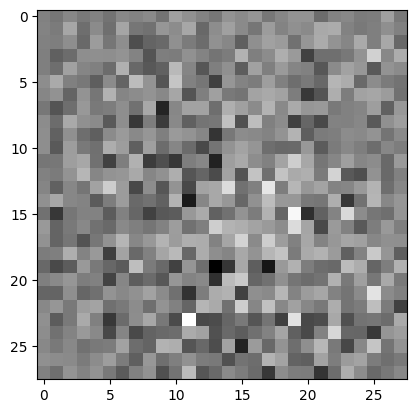

Time for epoch 1 is 23.153367519378662 sec


<Figure size 640x480 with 0 Axes>

Time for epoch 2 is 11.497797727584839 sec


<Figure size 640x480 with 0 Axes>

Time for epoch 3 is 11.634926319122314 sec


<Figure size 640x480 with 0 Axes>

Time for epoch 4 is 11.484628915786743 sec


<Figure size 640x480 with 0 Axes>

Time for epoch 5 is 11.340374946594238 sec


<Figure size 640x480 with 0 Axes>

Time for epoch 6 is 11.271778583526611 sec


<Figure size 640x480 with 0 Axes>

Time for epoch 7 is 11.258124589920044 sec


<Figure size 640x480 with 0 Axes>

Time for epoch 8 is 11.487061262130737 sec


<Figure size 640x480 with 0 Axes>

Time for epoch 9 is 11.521337747573853 sec


<Figure size 640x480 with 0 Axes>

Time for epoch 10 is 11.463292121887207 sec


<Figure size 640x480 with 0 Axes>

Time for epoch 11 is 11.408891201019287 sec


<Figure size 640x480 with 0 Axes>

Time for epoch 12 is 11.371164083480835 sec


<Figure size 640x480 with 0 Axes>

Time for epoch 13 is 11.357818841934204 sec


<Figure size 640x480 with 0 Axes>

Time for epoch 14 is 11.334900140762329 sec


<Figure size 640x480 with 0 Axes>

Time for epoch 15 is 11.483062028884888 sec


<Figure size 640x480 with 0 Axes>

Time for epoch 16 is 11.346769094467163 sec


<Figure size 640x480 with 0 Axes>

Time for epoch 17 is 11.354610443115234 sec


<Figure size 640x480 with 0 Axes>

Time for epoch 18 is 11.362367391586304 sec


<Figure size 640x480 with 0 Axes>

Time for epoch 19 is 11.37564492225647 sec


<Figure size 640x480 with 0 Axes>

Time for epoch 20 is 11.375700950622559 sec


<Figure size 640x480 with 0 Axes>

Time for epoch 21 is 11.393147945404053 sec


<Figure size 640x480 with 0 Axes>

Time for epoch 22 is 11.396857738494873 sec


<Figure size 640x480 with 0 Axes>

Time for epoch 23 is 11.420542478561401 sec


<Figure size 640x480 with 0 Axes>

Time for epoch 24 is 11.417190313339233 sec


<Figure size 640x480 with 0 Axes>

Time for epoch 25 is 11.412206172943115 sec


<Figure size 640x480 with 0 Axes>

Time for epoch 26 is 11.353727579116821 sec


<Figure size 640x480 with 0 Axes>

Time for epoch 27 is 11.347902536392212 sec


<Figure size 640x480 with 0 Axes>

Time for epoch 28 is 11.34415078163147 sec


<Figure size 640x480 with 0 Axes>

Time for epoch 29 is 11.3369140625 sec


<Figure size 640x480 with 0 Axes>

Time for epoch 30 is 11.4434974193573 sec


<Figure size 640x480 with 0 Axes>

Time for epoch 31 is 11.335345268249512 sec


<Figure size 640x480 with 0 Axes>

Time for epoch 32 is 11.330053806304932 sec


<Figure size 640x480 with 0 Axes>

Time for epoch 33 is 11.330174207687378 sec


<Figure size 640x480 with 0 Axes>

Time for epoch 34 is 11.335418701171875 sec


<Figure size 640x480 with 0 Axes>

Time for epoch 35 is 11.324800491333008 sec


<Figure size 640x480 with 0 Axes>

Time for epoch 36 is 11.32794737815857 sec


<Figure size 640x480 with 0 Axes>

Time for epoch 37 is 11.355670690536499 sec


<Figure size 640x480 with 0 Axes>

Time for epoch 38 is 11.417219638824463 sec


<Figure size 640x480 with 0 Axes>

Time for epoch 39 is 11.425007104873657 sec


<Figure size 640x480 with 0 Axes>

Time for epoch 40 is 11.402454614639282 sec


<Figure size 640x480 with 0 Axes>

Time for epoch 41 is 11.362425088882446 sec


<Figure size 640x480 with 0 Axes>

Time for epoch 42 is 11.36785101890564 sec


<Figure size 640x480 with 0 Axes>

Time for epoch 43 is 11.366106510162354 sec


<Figure size 640x480 with 0 Axes>

Time for epoch 44 is 11.374051570892334 sec


<Figure size 640x480 with 0 Axes>

Time for epoch 45 is 11.50490927696228 sec


<Figure size 640x480 with 0 Axes>

Time for epoch 46 is 11.38624358177185 sec


<Figure size 640x480 with 0 Axes>

Time for epoch 47 is 11.377537488937378 sec


<Figure size 640x480 with 0 Axes>

Time for epoch 48 is 11.389129400253296 sec


<Figure size 640x480 with 0 Axes>

Time for epoch 49 is 11.390366315841675 sec


<Figure size 640x480 with 0 Axes>

Time for epoch 50 is 11.37522554397583 sec


<Figure size 640x480 with 0 Axes>

In [12]:
# -*- coding: utf-8 -*-
import tensorflow as tf
from tensorflow.keras import layers
import time
import glob
import PIL
import imageio
import os
import numpy as np
import matplotlib.pyplot as plt


#loading the training and the testing images for mnist dataset from tensorlfow package
(train_images, test_images), (_, _) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape(train_images.shape[0],28,28,1).astype('float32')

#Normlaizing the images to be in the range of -1 to 1
train_images = (train_images - 127.5) / 127.5

BUFFER_SIZE = 60000
BATCH_SIZE = 256

#Batch and shuffle the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

def generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7,7,256)))
    assert model.output_shape == (None,7,7,256)

    model.add(layers.Conv2DTranspose(128,(5,5),strides=(1,1),padding = 'same',use_bias = False))
    assert model.output_shape == (None,7,7,128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64,(5,5),strides=(2,2),padding = 'same',use_bias = False))
    assert model.output_shape == (None,14,14,64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1,(5,5),strides=(2,2),padding = 'same',use_bias=False))
    assert model.output_shape == (None,28,28,1)

    return model

generator = generator_model()

noise = tf.random.normal([1,100])
generated_image  = generator(noise,training = False)

plt.imshow(generated_image[0,:,:,0],cmap='gray')

def discriminator_model():
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64,(5,5),strides=(2,2),padding='same',input_shape=[28,28,1]))

  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(128,(5,5),strides=(2,2),padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1))

  return model

discriminator = discriminator_model()
decision = discriminator(generated_image)
print(decision)

# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  generate_and_save_images(generator,
                           epochs,
                           seed)

def generate_and_save_images(model, epoch, test_input):
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

if __name__ == '__main__':
  train(train_dataset, EPOCHS)
